# Handwritten digits with Gans

For this project, we'll work on the MNIST dataset which is a dataset of handwritten numbers using the Generative Adversarial Networks.

Thus, we'll have 2 models : a Generator trying to create images and a Discriminator aiming to distinguish the images created by the generator from the real images. 

## Librairies

In [31]:
import tensorflow as tf 
import glob 
import matplotlib.pyplot as plt 
import numpy as np 
import os 
import time 
from IPython import display

## Data Import

In [32]:

(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
print(X_train[:2], y_train[:2])



[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]] [5 0]


## Pre-processing

### Reshape and Normalization

Here, we'll reshape the images so they look like : sample, height, width and channels = 1 (as Neural Networks receive inputs of same size)

Then we convert it to float 32 and we Normalize the images to get pixel within [-1,1] (to get similar distribution, it makes convergence faster while training the network)

In [33]:
train_images = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1).astype("float32")
train_images = (train_images - 255/2)/(255/2) 
train_images[:2]

array([[[[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [-1.],
         [-1.]],

        [[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [-1.],
         [-1.]],

        [[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [-1.],
         [-1.]],

        ...,

        [[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [-1.],
         [-1.]],

        [[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [-1.],
         [-1.]],

        [[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [-1.],
         [-1.]]],


       [[[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [-1.],
         [-1.]],

        [[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [-1.],
         [-1.]],

        [[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [

In [34]:
train_images.shape

(60000, 28, 28, 1)

In [52]:
train_images[0].shape

(28, 28, 1)

In [36]:
train_images[0].reshape(-1,28).shape

(28, 28)

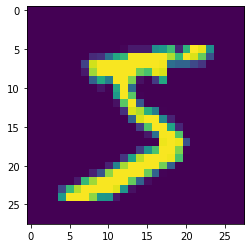

In [37]:
#Vizualisation of an image
plt.imshow(train_images[0].squeeze())

## Dataset

In [45]:
BUFFER_SIZE = 60000
BATCH_SIZE =256 #Number of training examples utilized in one iteration

train_set = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [46]:
#Fetch image in train set and look at the shape
next(iter(train_set.take(1))).shape

TensorShape([256, 28, 28, 1])

In [47]:
for i in train_set.take(1):
  print(i)

tf.Tensor(
[[[[-1.]
   [-1.]
   [-1.]
   ...
   [-1.]
   [-1.]
   [-1.]]

  [[-1.]
   [-1.]
   [-1.]
   ...
   [-1.]
   [-1.]
   [-1.]]

  [[-1.]
   [-1.]
   [-1.]
   ...
   [-1.]
   [-1.]
   [-1.]]

  ...

  [[-1.]
   [-1.]
   [-1.]
   ...
   [-1.]
   [-1.]
   [-1.]]

  [[-1.]
   [-1.]
   [-1.]
   ...
   [-1.]
   [-1.]
   [-1.]]

  [[-1.]
   [-1.]
   [-1.]
   ...
   [-1.]
   [-1.]
   [-1.]]]


 [[[-1.]
   [-1.]
   [-1.]
   ...
   [-1.]
   [-1.]
   [-1.]]

  [[-1.]
   [-1.]
   [-1.]
   ...
   [-1.]
   [-1.]
   [-1.]]

  [[-1.]
   [-1.]
   [-1.]
   ...
   [-1.]
   [-1.]
   [-1.]]

  ...

  [[-1.]
   [-1.]
   [-1.]
   ...
   [-1.]
   [-1.]
   [-1.]]

  [[-1.]
   [-1.]
   [-1.]
   ...
   [-1.]
   [-1.]
   [-1.]]

  [[-1.]
   [-1.]
   [-1.]
   ...
   [-1.]
   [-1.]
   [-1.]]]


 [[[-1.]
   [-1.]
   [-1.]
   ...
   [-1.]
   [-1.]
   [-1.]]

  [[-1.]
   [-1.]
   [-1.]
   ...
   [-1.]
   [-1.]
   [-1.]]

  [[-1.]
   [-1.]
   [-1.]
   ...
   [-1.]
   [-1.]
   [-1.]]

  ...

  [[-1.]
   [-1.]
 

# Generator

The model will take as input random pixels (noise). They will go through series of layers which will produce an image from the random seed.

In [84]:
 #LeakyRelu Because it does not set neuron to 0 if not active but leaves gradient

In [53]:
def make_generator_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(7*7*256, use_bias=False, input_shape=(100,)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
        
        tf.keras.layers.Reshape((7,7, 256)),
        
        tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
        
        tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
        
        tf.keras.layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation="tanh")
        
                                ])

    return model

Let's look at an example

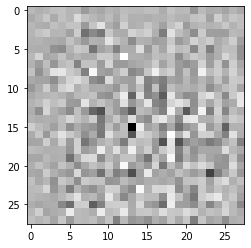

In [58]:


### model instantiation
generator = make_generator_model()

### Random pixel size creation (1, 100)
random_pixels = tf.random.normal([1,100])

### Model application
rand_img = generator(random_pixels, training=False)

### Model visualisation
plt.imshow(rand_img.numpy().squeeze(), cmap="gray")



It works but as expected, it is unreadable

In [59]:
generator.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 12544)             1254400   
_________________________________________________________________
batch_normalization_9 (Batch (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 12544)             0         
_________________________________________________________________
reshape_3 (Reshape)          (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose_9 (Conv2DTr (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_10 (Batc (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 7, 7, 128)        

# Discrimator

So here, the goal is to create simple binary CNN predicting if the image is fake or not

In [60]:
def make_discriminator_model():
  
    model = tf.keras.Sequential([
        
        tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Dropout(0.3),
        
        tf.keras.layers.Conv2D(128, (5,5), strides=(2,2), padding="same"),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Dropout(0.3),
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1)
        #tf.keras.layers.Dense(1, activation = "sigmoid")        
    ])

    return model

Example here : 

In [61]:
discriminator = make_discriminator_model()
discriminator(rand_img, training=False)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00218681]], dtype=float32)>

# Cost Functions

In [63]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
# cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)
cross_entropy

In [64]:
#Define how well our discrimator distinuishes false from real
def discriminator_loss(real_outputs, fake_outputs):
  real_loss = cross_entropy(tf.ones_like(real_outputs), real_outputs)
  fake_loss = cross_entropy(tf.zeros_like(fake_outputs), fake_outputs)
  
  total_loss = real_loss + fake_loss 
  return total_loss

In [66]:
#Define how well the model fool the discriminator, if the descriminator defines a fake image as atrue image' it should lower the `generator_loss'.
def generator_loss(fake_outputs):
  return cross_entropy(tf.ones_like(fake_outputs), fake_outputs)

In [67]:
#optimizers for our two cost functions.
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [80]:
# Noise dim : The dimension of our random tensor
# num examples : We will create 16 random images
# seed : Our random images

In [79]:
EPOCHS = 70
noise_dim = 100
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])

We will now define a train_step function that will define how a step in the model training will occur._gradients


In [81]:

# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

Before applying our training function, we will have to create a last function that will allow us to generate and save an image.

In [82]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

Let's start the training

(Had to stop early, computer was overheating)

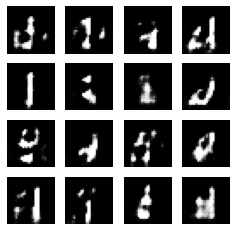

Time for epoch 7 is 178.0794641971588 sec


KeyboardInterrupt: 

In [83]:
EPOCHS = 100
for epoch in range(EPOCHS):
  start = time.time()

  for image_batch in train_set:
    train_step(image_batch)

  # Save the new image 
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epoch + 1,
                           seed)

  print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

# Generate the new image 
display.clear_output(wait=True)
generate_and_save_images(generator,
                         EPOCHS,
                         seed)